Goal reached
Found path!


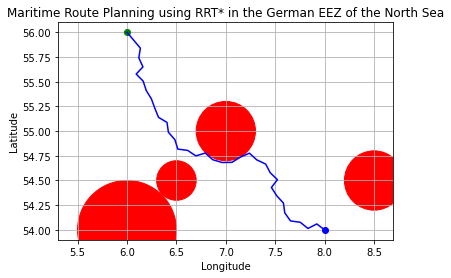

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None

class RRTStar:
    def __init__(self, start, goal, obstacles, x_lim, y_lim, step_size=0.1, goal_sample_rate=0.05, max_iter=10000):
        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.obstacles = obstacles
        self.x_lim = x_lim
        self.y_lim = y_lim
        self.step_size = step_size
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.nodes = [self.start]

    def get_random_node(self):
        if random.random() > self.goal_sample_rate:
            return Node(random.uniform(self.x_lim[0], self.x_lim[1]), random.uniform(self.y_lim[0], self.y_lim[1]))
        else:
            return self.goal

    def get_nearest_node_index(self, node):
        distances = [(n.x - node.x) ** 2 + (n.y - node.y) ** 2 for n in self.nodes]
        return distances.index(min(distances))

    def steer(self, from_node, to_node):
        new_node = Node(from_node.x, from_node.y)
        d, theta = self.get_distance_and_angle(from_node, to_node)
        new_node.x += self.step_size * np.cos(theta)
        new_node.y += self.step_size * np.sin(theta)
        new_node.parent = from_node
        return new_node

    def get_distance_and_angle(self, from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        distance = np.hypot(dx, dy)
        angle = np.arctan2(dy, dx)
        return distance, angle

    def is_collision_free(self, node):
        for (ox, oy, radius) in self.obstacles:
            if (node.x - ox) ** 2 + (node.y - oy) ** 2 <= radius ** 2:
                return False
        return True

    def rewire(self, new_node, near_indices):
        for i in near_indices:
            near_node = self.nodes[i]
            d, _ = self.get_distance_and_angle(new_node, near_node)
            s = new_node.parent
            if self.is_collision_free(new_node) and d + self.get_distance_and_angle(s, new_node)[0] < self.get_distance_and_angle(s, near_node)[0]:
                near_node.parent = new_node

    def get_near_indices(self, new_node):
        n = len(self.nodes) + 1
        r = 50.0 * np.sqrt((np.log(n) / n))  # radius of search
        distances = [(node.x - new_node.x) ** 2 + (node.y - new_node.y) ** 2 for node in self.nodes]
        near_indices = [distances.index(d) for d in distances if d <= r ** 2]
        return near_indices

    def generate_final_course(self, goal_index):
        path = [[self.goal.x, self.goal.y]]
        node = self.nodes[goal_index]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])
        return path

    def planning(self):
        for _ in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_index = self.get_nearest_node_index(rnd_node)
            nearest_node = self.nodes[nearest_index]
            new_node = self.steer(nearest_node, rnd_node)

            if self.is_collision_free(new_node):
                near_indices = self.get_near_indices(new_node)
                self.nodes.append(new_node)
                self.rewire(new_node, near_indices)

            if self.get_distance_and_angle(new_node, self.goal)[0] <= self.step_size:
                print("Goal reached")
                return self.generate_final_course(len(self.nodes) - 1)

        return None

def plot_path(obstacles, path, start, goal):
    fig, ax = plt.subplots()
    for (ox, oy, radius) in obstacles:
        circle = plt.Circle((ox, oy), radius, color='r', fill=True)
        ax.add_artist(circle)

    ax.plot(start[0], start[1], "bo")
    ax.plot(goal[0], goal[1], "go")
    path = np.array(path)
    ax.plot(path[:, 0], path[:, 1], "b-")
    plt.grid(True)
    plt.axis("equal")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Maritime Route Planning using RRT* in the German EEZ of the North Sea')
    plt.show()

def main():
    start = [8.0, 54.0]  # Example start coordinate within the German EEZ
    goal = [6.0, 56.0]   # Example goal coordinate within the German EEZ
    # Example obstacles (longitude, latitude, radius)
    obstacles = [
        (7.0, 55.0, 0.3),
        (6.5, 54.5, 0.2),
        (6.0, 54.0, 0.5),
        (8.5, 54.5, 0.3)
    ]
    x_lim = [5.0, 9.0]  # Longitude bounds for the German EEZ in the North Sea
    y_lim = [53.0, 57.0] # Latitude bounds for the German EEZ in the North Sea

    rrt_star = RRTStar(start, goal, obstacles, x_lim, y_lim)
    path = rrt_star.planning()

    if path is None:
        print("No path found")
    else:
        print("Found path!")
        plot_path(obstacles, path, start, goal)

if __name__ == '__main__':
    main()
